<a href="https://colab.research.google.com/github/Ranazzi/GANparam/blob/main/ProjetoGANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [3]:
!pip install mat73

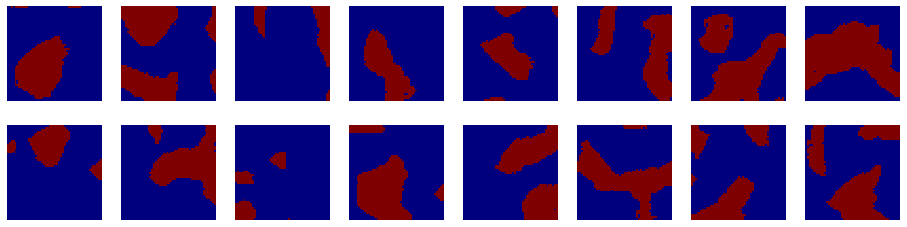

In [8]:
# Load the dataset
import mat73
X_train_raw = mat73.loadmat('gdrive/My Drive/Colab Notebooks/Projeto/K500.mat')['K500']

X_train_raw = np.reshape(X_train_raw, (50, 50, 500))
X_train_raw = np.einsum('xyn->nxy', X_train_raw)

r, c = 2, 8
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train_raw[cnt,:,:], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

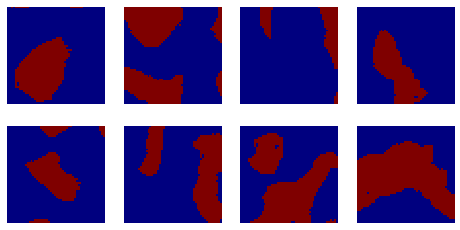

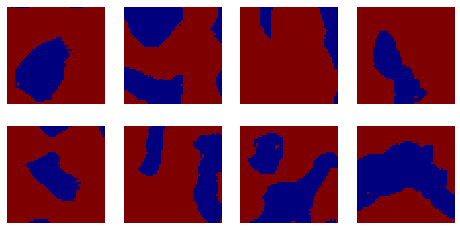

In [9]:
# #decompose into two channels
X_train=np.zeros((X_train_raw.shape[0],X_train_raw.shape[1],X_train_raw.shape[2],2))
for i in range(X_train_raw.shape[0]):
  for j in range(X_train_raw.shape[1]):
    for k in range(X_train_raw.shape[2]):
      if X_train_raw[i,j,k]==1:
        X_train[i,j,k,0]=1
        X_train[i,j,k,1]=-1
      else:
        X_train[i,j,k,1]=1
        X_train[i,j,k,0]=-1

r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,0], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()
r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,1], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [11]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(7*7*128, activation = 'relu', input_dim=latent_dim)) #camada densa
  model.add(layers.Reshape((7, 7, 128))) #reshape

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=2, strides=1, padding="valid")) #convd2 3x3 com stride de 1

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.UpSampling2D())
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding="valid")) #convd2 3x3 com stride de 1
  model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.Conv2D(2, kernel_size=3, strides=1, padding="same", activation = 'tanh')) #convd2 3x3 com stride de 1 e actv tanh

  # model.summary()
  
  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  # model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)

  #get maximum activation value as facie type
  faciet=np.zeros((gen_imgs.shape[0],gen_imgs.shape[1],gen_imgs.shape[2]))

  for i in range(gen_imgs.shape[0]):
   for j in range(gen_imgs.shape[1]):
    for k in range(gen_imgs.shape[2]):
      if gen_imgs[i,j,k,0] > gen_imgs[i,j,k,1]:
        faciet[i,j,k]=1

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(faciet[cnt,:,:], aspect='equal', cmap = cm.jet, interpolation = 'none',clim = (0, 1))
          axs[i,j].axis('off')
          cnt += 1
  plt.show()
  plt.close()

In [12]:
img_shape = (50, 50, 2)
latent_dim = 500

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 2)]       0         
                                                                 
 sequential (Sequential)     (None, 1)                 400673    
                                                                 
Total params: 400,673
Trainable params: 400,673
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 model_1 (Functional)        (None, 50, 50, 2)         3448994   
                                                                 
 model (Functional)          (None, 1)

In [13]:
#normalization
batch_size=64
# Re-escale de -1 a 1
# X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3)

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

0 [D loss: 0.696536, acc.: 35.94%] [G loss: 0.619508]


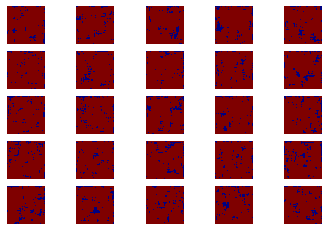

25 [D loss: 0.624071, acc.: 67.19%] [G loss: 0.862390]


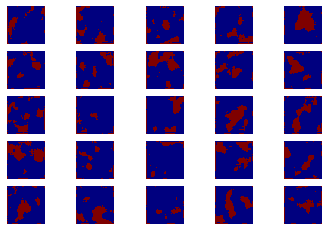

50 [D loss: 0.702500, acc.: 46.09%] [G loss: 0.682627]


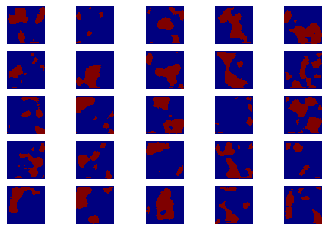

75 [D loss: 0.707734, acc.: 44.53%] [G loss: 0.656630]


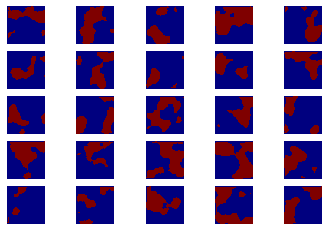

100 [D loss: 0.687775, acc.: 50.78%] [G loss: 0.667993]


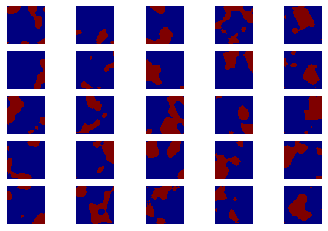

125 [D loss: 0.694736, acc.: 50.78%] [G loss: 0.654975]


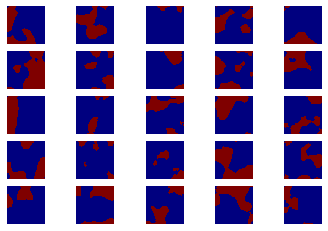

150 [D loss: 0.688736, acc.: 51.56%] [G loss: 0.672133]


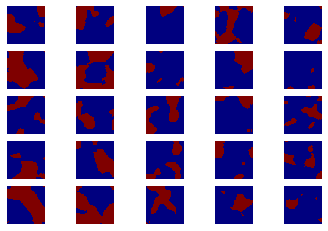

175 [D loss: 0.696156, acc.: 43.75%] [G loss: 0.667260]


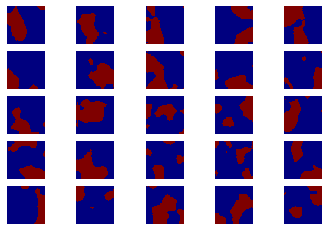

200 [D loss: 0.682970, acc.: 52.34%] [G loss: 0.679115]


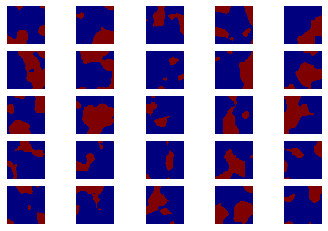

225 [D loss: 0.685156, acc.: 51.56%] [G loss: 0.673317]


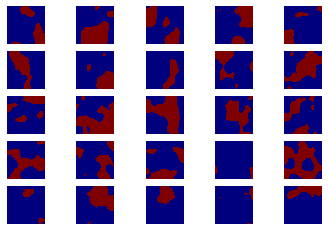

250 [D loss: 0.680500, acc.: 58.59%] [G loss: 0.680922]


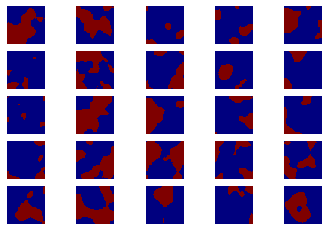

275 [D loss: 0.688422, acc.: 53.12%] [G loss: 0.680018]


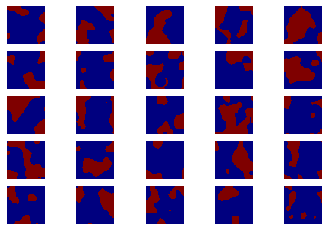

300 [D loss: 0.680972, acc.: 59.38%] [G loss: 0.703834]


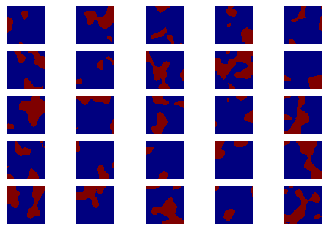

325 [D loss: 0.679795, acc.: 56.25%] [G loss: 0.713952]


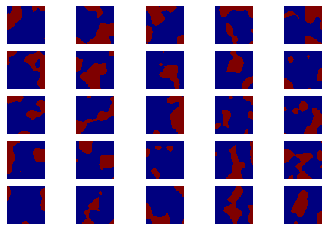

350 [D loss: 0.678706, acc.: 64.06%] [G loss: 0.719606]


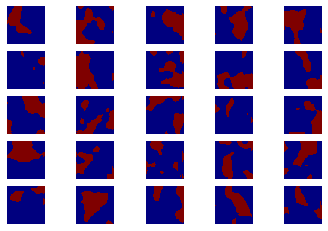

375 [D loss: 0.682481, acc.: 52.34%] [G loss: 0.710508]


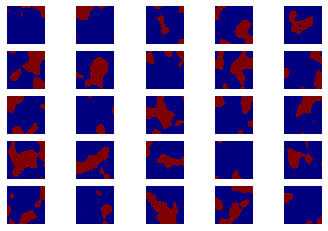

400 [D loss: 0.680663, acc.: 58.59%] [G loss: 0.716958]


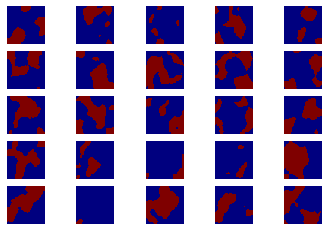

425 [D loss: 0.679087, acc.: 60.16%] [G loss: 0.705538]


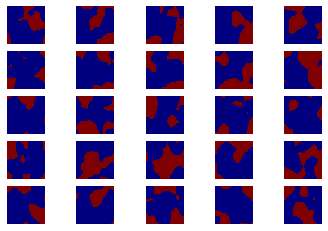

450 [D loss: 0.662766, acc.: 63.28%] [G loss: 0.969815]


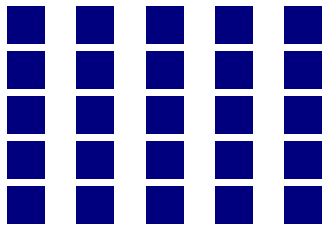

475 [D loss: 0.443927, acc.: 93.75%] [G loss: 0.769777]


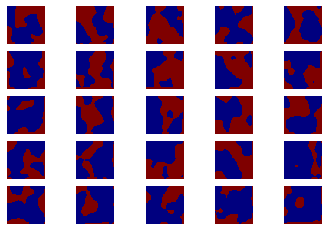

500 [D loss: 0.725732, acc.: 60.16%] [G loss: 0.684353]


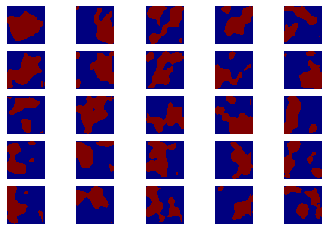

525 [D loss: 0.658079, acc.: 64.06%] [G loss: 0.851349]


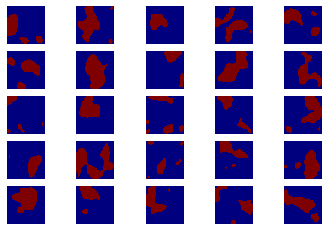

550 [D loss: 0.591988, acc.: 73.44%] [G loss: 0.561547]


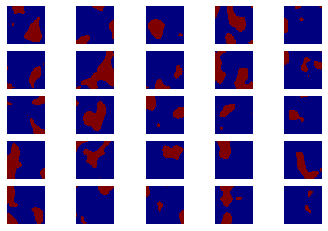

575 [D loss: 0.608575, acc.: 71.88%] [G loss: 1.279214]


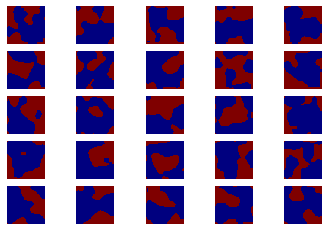

600 [D loss: 1.328288, acc.: 14.84%] [G loss: 2.830318]


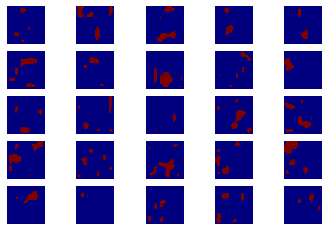

625 [D loss: 0.442254, acc.: 82.81%] [G loss: 0.340820]


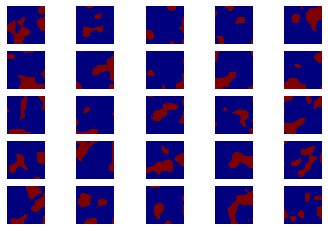

650 [D loss: 0.537465, acc.: 70.31%] [G loss: 1.043739]


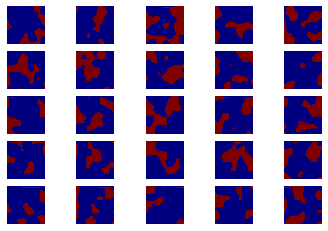

675 [D loss: 0.502548, acc.: 77.34%] [G loss: 1.808235]


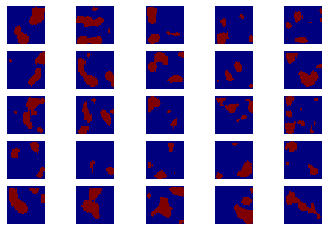

700 [D loss: 0.426468, acc.: 80.47%] [G loss: 0.080430]


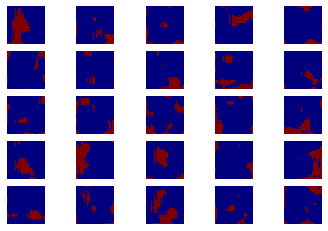

725 [D loss: 0.039098, acc.: 100.00%] [G loss: 0.142039]


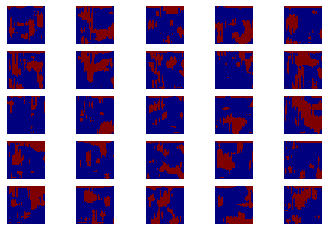

750 [D loss: 0.551888, acc.: 77.34%] [G loss: 1.332972]


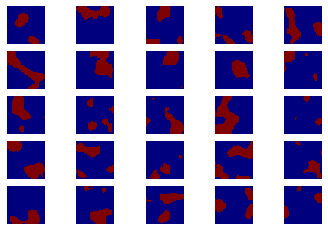

775 [D loss: 0.427639, acc.: 79.69%] [G loss: 0.746639]


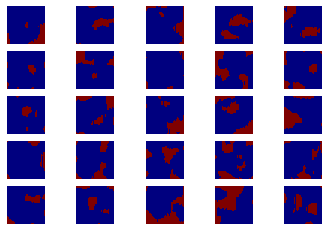

800 [D loss: 0.806594, acc.: 53.12%] [G loss: 1.723724]


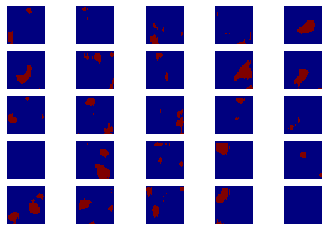

825 [D loss: 0.060170, acc.: 97.66%] [G loss: 3.314811]


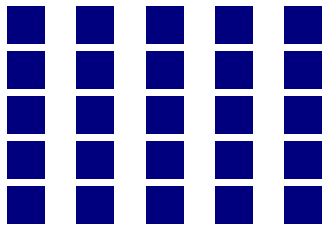

850 [D loss: 0.111336, acc.: 96.09%] [G loss: 3.121593]


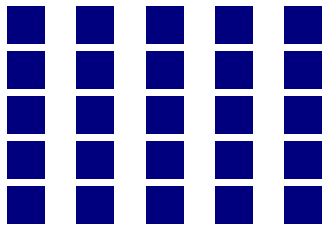

875 [D loss: 0.033457, acc.: 99.22%] [G loss: 4.108117]


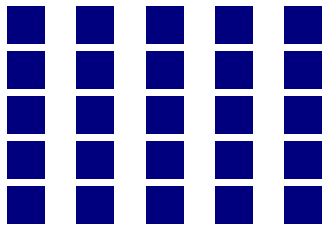

900 [D loss: 0.023282, acc.: 99.22%] [G loss: 4.206380]


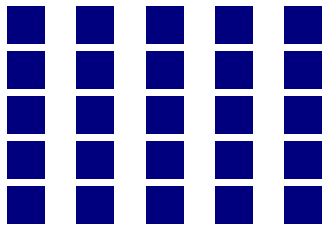

925 [D loss: 0.009511, acc.: 100.00%] [G loss: 4.284326]


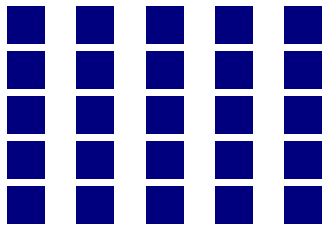

950 [D loss: 0.025826, acc.: 98.44%] [G loss: 4.262524]


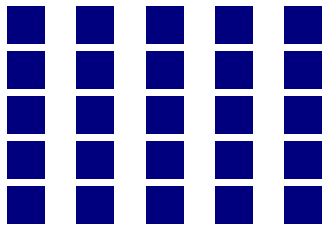

975 [D loss: 0.108920, acc.: 97.66%] [G loss: 3.889345]


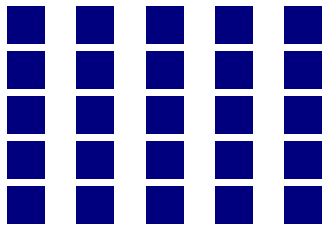

1000 [D loss: 0.088575, acc.: 97.66%] [G loss: 3.664770]


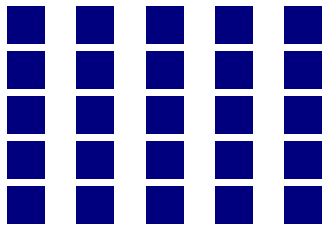

1025 [D loss: 0.069561, acc.: 98.44%] [G loss: 4.267797]


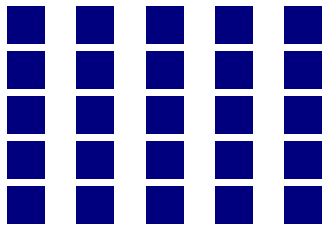

1050 [D loss: 0.014138, acc.: 99.22%] [G loss: 4.950572]


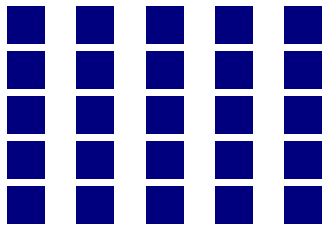

1075 [D loss: 0.044302, acc.: 99.22%] [G loss: 4.801905]


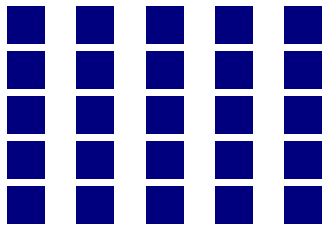

1100 [D loss: 0.024996, acc.: 99.22%] [G loss: 4.805735]


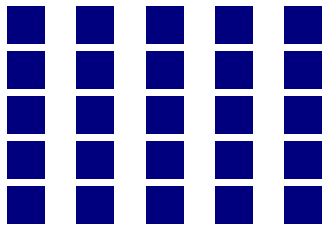

1125 [D loss: 0.028564, acc.: 99.22%] [G loss: 4.985332]


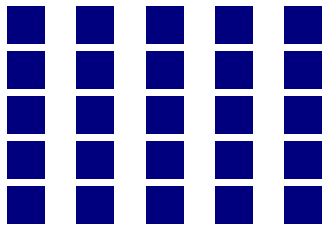

1150 [D loss: 0.005185, acc.: 100.00%] [G loss: 5.392282]


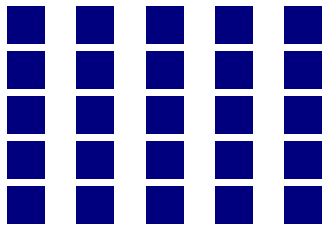

1175 [D loss: 0.002264, acc.: 100.00%] [G loss: 5.622813]


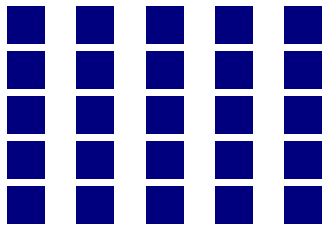

1200 [D loss: 0.004546, acc.: 100.00%] [G loss: 5.170758]


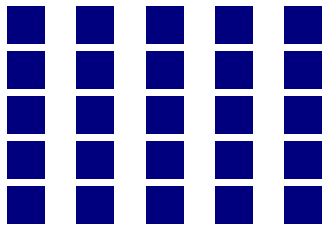

1225 [D loss: 0.004763, acc.: 100.00%] [G loss: 5.343749]


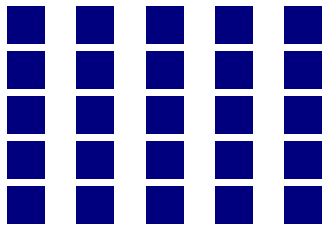

1250 [D loss: 0.001602, acc.: 100.00%] [G loss: 6.052917]


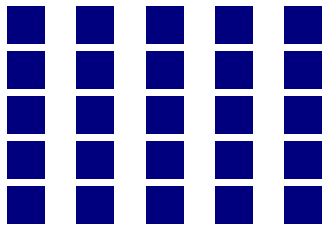

1275 [D loss: 0.045259, acc.: 98.44%] [G loss: 4.515321]


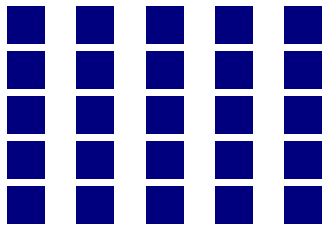

1300 [D loss: 0.009052, acc.: 99.22%] [G loss: 5.204123]


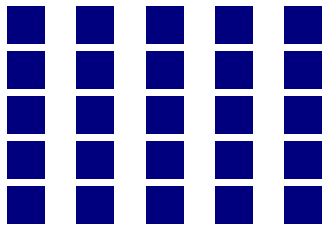

1325 [D loss: 0.001083, acc.: 100.00%] [G loss: 6.527535]


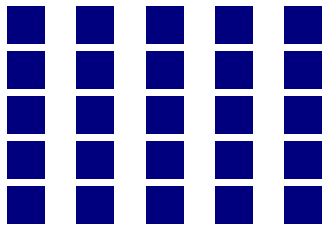

1350 [D loss: 0.002418, acc.: 100.00%] [G loss: 6.864152]


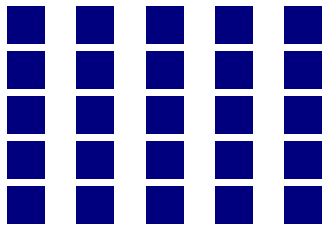

1375 [D loss: 0.001509, acc.: 100.00%] [G loss: 6.114601]


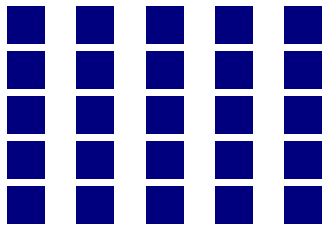

1400 [D loss: 0.715939, acc.: 65.62%] [G loss: 1.400918]


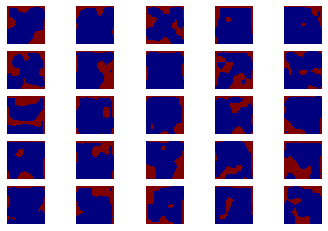

1425 [D loss: 0.372829, acc.: 82.81%] [G loss: 1.944749]


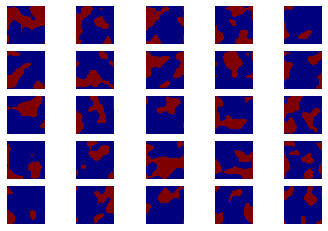

1450 [D loss: 0.516948, acc.: 72.66%] [G loss: 2.464475]


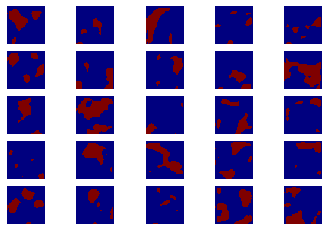

1475 [D loss: 0.422006, acc.: 81.25%] [G loss: 1.367966]


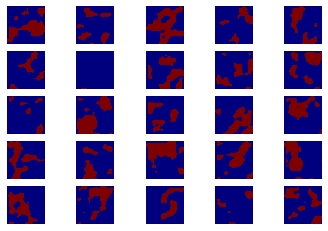

1500 [D loss: 0.565110, acc.: 67.97%] [G loss: 1.786064]


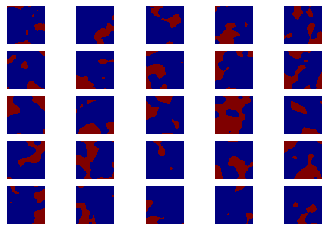

1525 [D loss: 0.414124, acc.: 79.69%] [G loss: 1.991889]


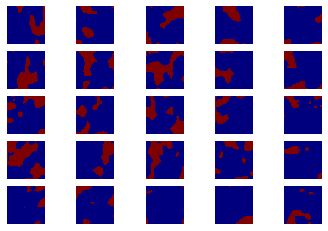

1550 [D loss: 0.410190, acc.: 82.03%] [G loss: 1.926328]


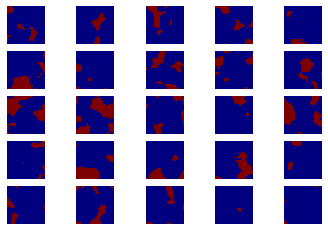

1575 [D loss: 0.454145, acc.: 78.91%] [G loss: 2.062476]


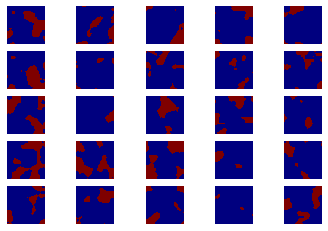

1600 [D loss: 0.465716, acc.: 81.25%] [G loss: 2.090576]


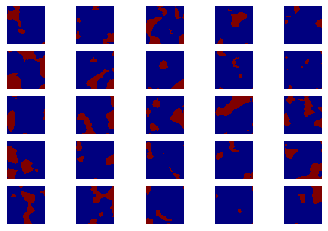

1625 [D loss: 0.441571, acc.: 81.25%] [G loss: 1.887866]


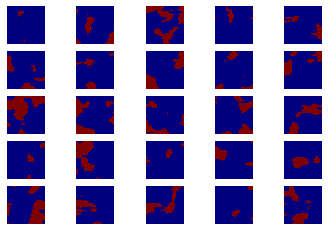

1650 [D loss: 0.390080, acc.: 85.94%] [G loss: 1.733718]


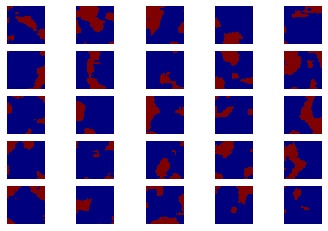

1675 [D loss: 0.458783, acc.: 80.47%] [G loss: 2.197758]


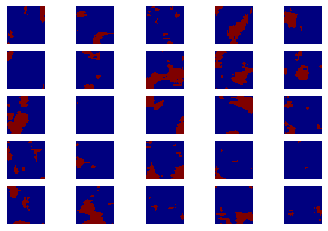

1700 [D loss: 0.473542, acc.: 77.34%] [G loss: 2.129019]


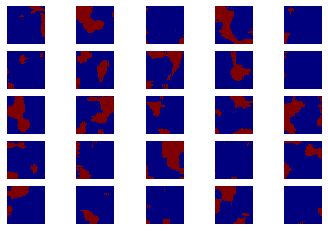

1725 [D loss: 0.441907, acc.: 78.12%] [G loss: 2.008333]


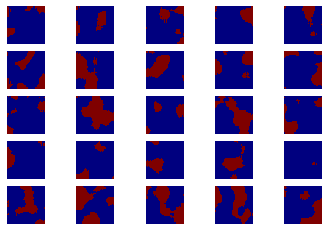

1750 [D loss: 0.414517, acc.: 81.25%] [G loss: 1.733427]


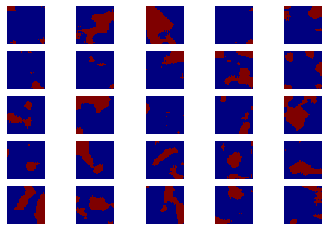

1775 [D loss: 0.391446, acc.: 85.94%] [G loss: 2.053477]


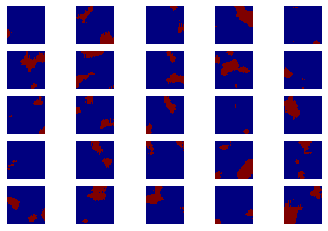

1800 [D loss: 0.410341, acc.: 81.25%] [G loss: 1.832541]


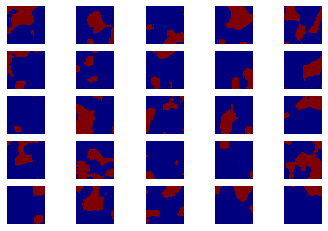

1825 [D loss: 0.448058, acc.: 83.59%] [G loss: 1.994553]


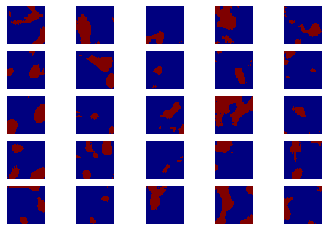

1850 [D loss: 0.372500, acc.: 83.59%] [G loss: 1.785637]


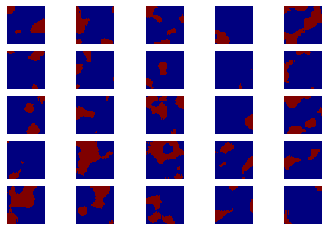

1875 [D loss: 0.339596, acc.: 90.62%] [G loss: 2.298998]


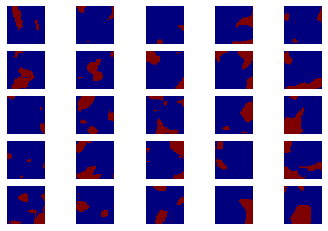

1900 [D loss: 0.371412, acc.: 83.59%] [G loss: 2.161598]


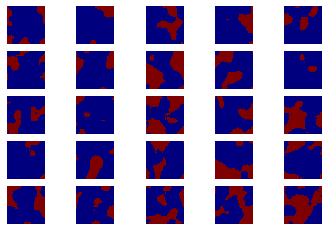

1925 [D loss: 0.343902, acc.: 85.16%] [G loss: 2.549908]


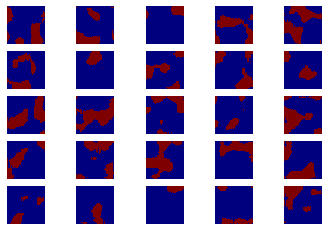

1950 [D loss: 0.437686, acc.: 79.69%] [G loss: 2.527763]


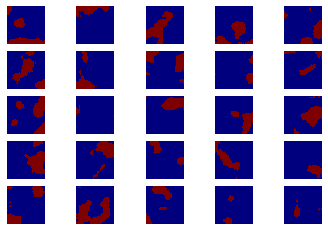

1975 [D loss: 0.392131, acc.: 84.38%] [G loss: 2.624510]


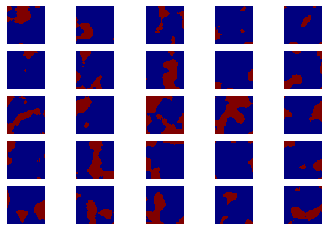

2000 [D loss: 0.329888, acc.: 86.72%] [G loss: 2.172105]


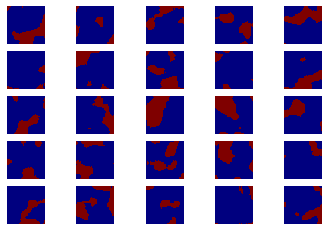

2025 [D loss: 0.238792, acc.: 89.84%] [G loss: 2.423940]


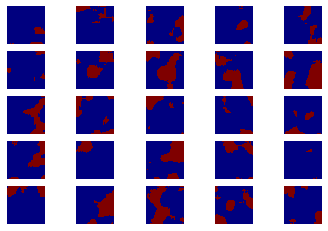

2050 [D loss: 0.391245, acc.: 78.12%] [G loss: 2.278968]


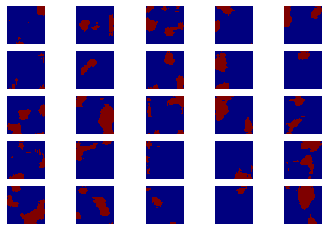

2075 [D loss: 0.323729, acc.: 85.16%] [G loss: 2.424679]


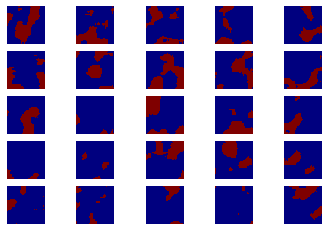

2100 [D loss: 0.349503, acc.: 85.94%] [G loss: 2.091133]


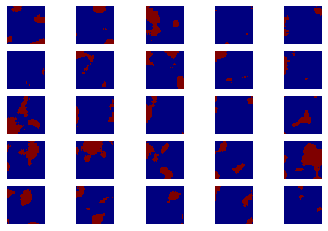

2125 [D loss: 0.217477, acc.: 93.75%] [G loss: 2.802856]


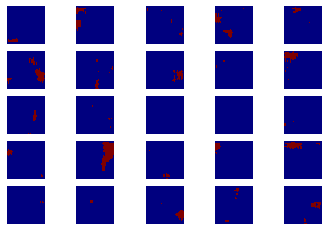

2150 [D loss: 0.371583, acc.: 86.72%] [G loss: 2.599038]


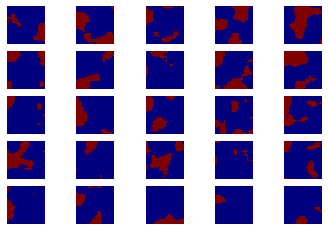

2175 [D loss: 0.283693, acc.: 90.62%] [G loss: 2.776530]


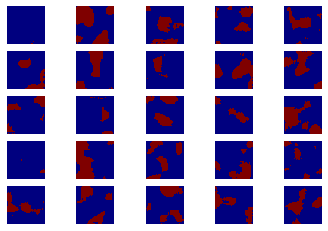

2200 [D loss: 0.335949, acc.: 81.25%] [G loss: 2.649768]


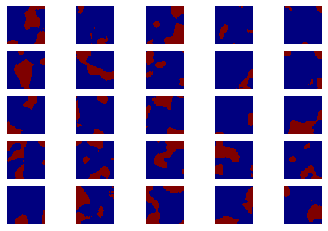

2225 [D loss: 0.268381, acc.: 91.41%] [G loss: 2.564023]


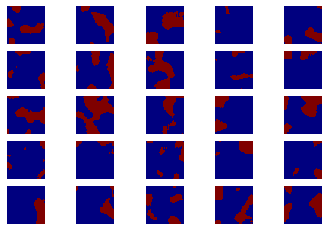

2250 [D loss: 0.279147, acc.: 91.41%] [G loss: 2.865278]


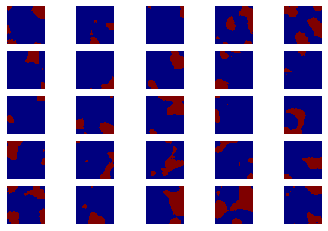

2275 [D loss: 0.327159, acc.: 85.16%] [G loss: 2.863566]


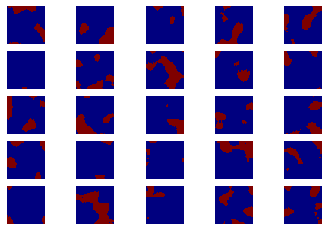

2300 [D loss: 0.284639, acc.: 87.50%] [G loss: 2.867106]


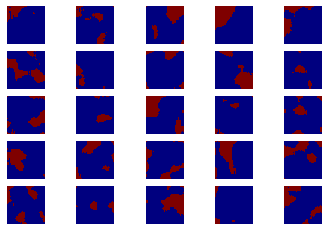

2325 [D loss: 0.191256, acc.: 93.75%] [G loss: 2.697449]


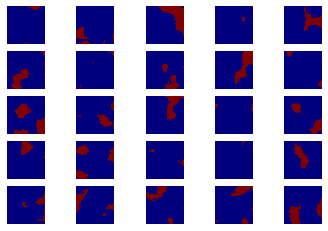

2350 [D loss: 0.317889, acc.: 85.94%] [G loss: 2.650145]


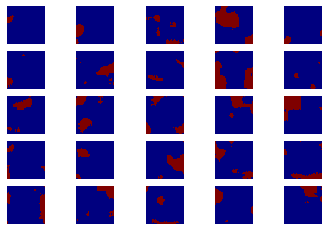

2375 [D loss: 0.194118, acc.: 93.75%] [G loss: 2.979905]


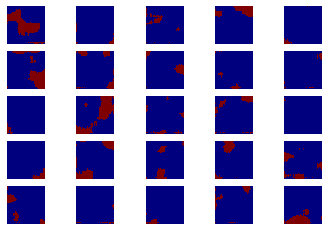

2400 [D loss: 0.212557, acc.: 90.62%] [G loss: 3.138534]


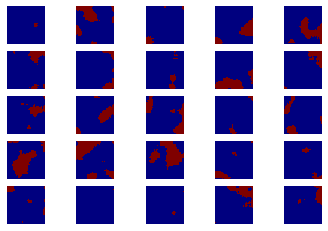

2425 [D loss: 0.245797, acc.: 92.97%] [G loss: 2.607850]


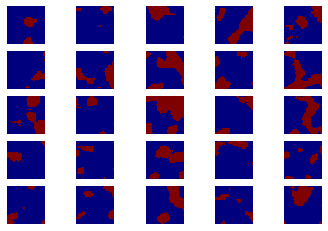

2450 [D loss: 0.185734, acc.: 91.41%] [G loss: 2.801364]


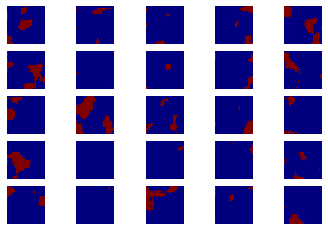

2475 [D loss: 0.245425, acc.: 90.62%] [G loss: 2.373946]


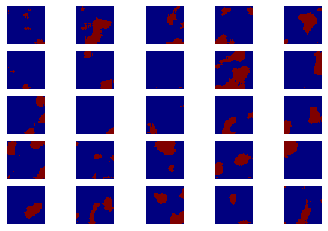

2500 [D loss: 0.204899, acc.: 92.19%] [G loss: 2.979815]


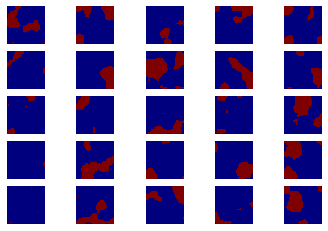

2525 [D loss: 0.338633, acc.: 86.72%] [G loss: 2.917863]


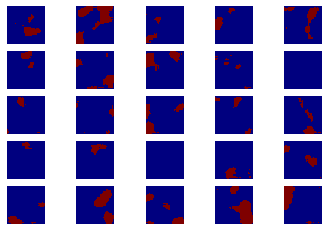

2550 [D loss: 0.298732, acc.: 87.50%] [G loss: 2.715938]


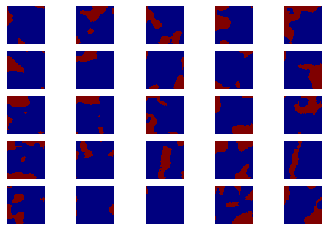

2575 [D loss: 0.263402, acc.: 88.28%] [G loss: 2.968470]


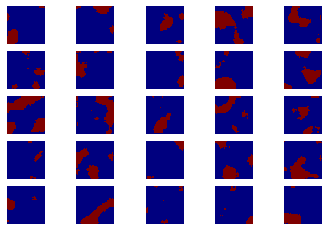

2600 [D loss: 0.237032, acc.: 89.84%] [G loss: 3.207885]


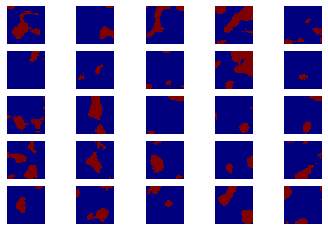

2625 [D loss: 0.236383, acc.: 92.97%] [G loss: 3.044924]


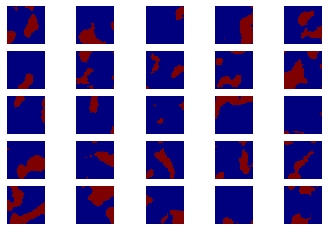

2650 [D loss: 0.168679, acc.: 92.97%] [G loss: 3.592712]


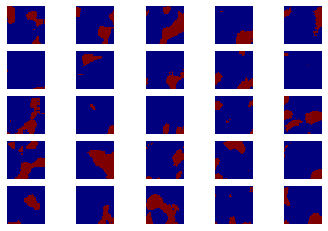

2675 [D loss: 0.238594, acc.: 87.50%] [G loss: 2.755288]


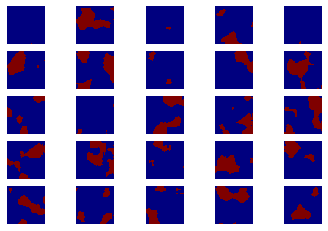

2700 [D loss: 0.294982, acc.: 90.62%] [G loss: 2.817355]


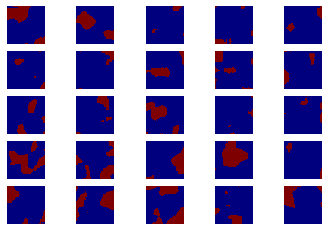

2725 [D loss: 0.275282, acc.: 89.06%] [G loss: 2.781833]


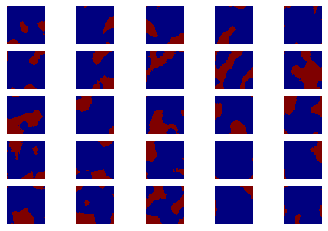

2750 [D loss: 0.213920, acc.: 93.75%] [G loss: 3.206286]


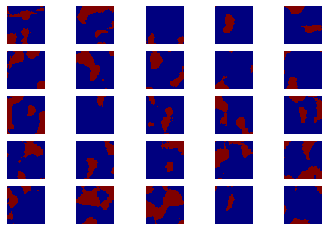

2775 [D loss: 0.238248, acc.: 90.62%] [G loss: 3.571837]


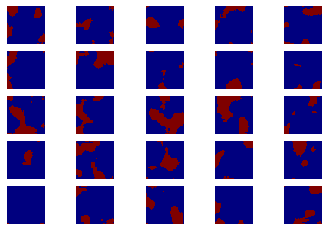

2800 [D loss: 0.175700, acc.: 92.97%] [G loss: 3.312250]


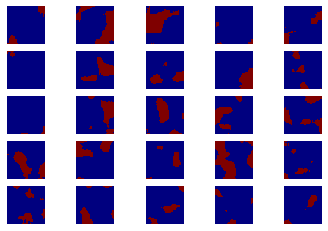

2825 [D loss: 0.163965, acc.: 92.97%] [G loss: 2.682548]


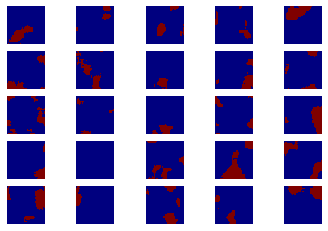

2850 [D loss: 0.218403, acc.: 89.84%] [G loss: 3.541566]


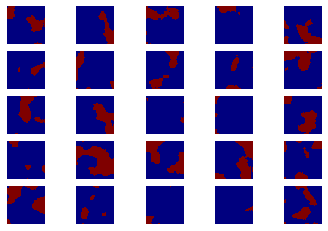

2875 [D loss: 0.195699, acc.: 93.75%] [G loss: 3.258414]


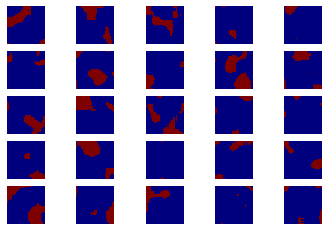

2900 [D loss: 0.271554, acc.: 89.06%] [G loss: 3.012283]


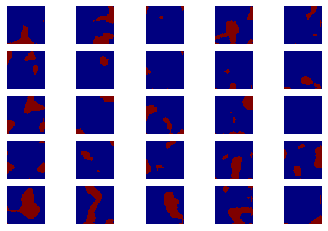

2925 [D loss: 0.229467, acc.: 93.75%] [G loss: 2.926681]


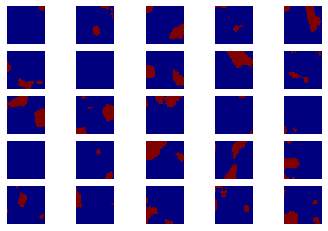

2950 [D loss: 0.182903, acc.: 92.97%] [G loss: 3.620723]


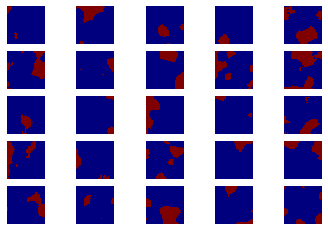

2975 [D loss: 0.220917, acc.: 91.41%] [G loss: 3.560766]


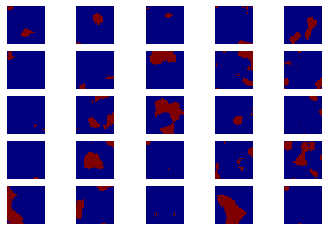

In [14]:
iterations=3000
sample_interval=25

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)